# Thema 3 werkcollege 3: Transformers
We gaan hier door met de 'videogames review' dataset van vorige week. Vorige keer zagen we dat we met diverse Recurrent Neural Netwerken eigenlijk steeds niet hoger kwamen dan een validated accuracy van net onder de 91%. Transformers bieden een alternatieve en modernere aanpak, welke we hier verder gaan verkennen. 

Om te beginnen lezen we hier de dataset weer in; tokenizen we deze; voegen we padding toe. Aangezien we deze stappen nu wel begrijpen doen we het nu met behulp van een <u>vectorization layer</u>. Dit vraagt wel wat voorbereiding aangezien we hiervoor onze train en test dataframes om moeten zetten naar een dataset object. Dit heeft onder andere als voordeel dat we niet alles in 1 keer in het geheugen hoeven te laden. Nu is dit hier nog niet zo van belang, maar bij grotere datasets wel. 

Bestudeer onderstaande code, voer deze uit, en probeer te begrijpen wat het doet. (zie ook:  https://www.tensorflow.org/guide/data) en https://medium.com/analytics-vidhya/getting-started-with-tensorflow-input-pipeline-aa0f31eea74a

In [1]:
import pandas as pd
df= pd.read_excel('../Data/gamereviews.xlsx')
text=df['reviewText'].astype('str')
sentiment=df['sentiment'].astype('int')
print(text.head())
print(sentiment.head())
print(sentiment.sum())

0    If you're looking for immersive gameplay, good...
1    The zippers on this bag are terrible. I ordere...
2    If you need a good intro to Wii games, this is...
3    This game has brought back so many great memor...
4    True Crime: Streets of LA was my first experie...
Name: reviewText, dtype: object
0    0
1    0
2    1
3    1
4    1
Name: sentiment, dtype: int64
50000


In [2]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_targets, test_targets = train_test_split(
        text, sentiment,
        test_size=0.2,
        random_state=1,
        shuffle = True,
        stratify=sentiment
    )

In [ ]:
import tensorflow as tf

#omzetten naar tensorflow dataobject met een batch_size van 64
train_text = tf.data.Dataset.from_tensor_slices(tf.cast(train_features.values, tf.string)).batch(64) #default batch is 32
train_cat = tf.data.Dataset.from_tensor_slices(tf.cast(train_targets.values, tf.int64)).batch(64)
test_text = tf.data.Dataset.from_tensor_slices(tf.cast(test_features.values, tf.string)).batch(64)
test_cat = tf.data.Dataset.from_tensor_slices(tf.cast(test_targets.values, tf.int64)).batch(64)

for each in train_text.take(3): #toon de 1e 3 reviews
  print(each)

In [ ]:
#samenvoegen naar 1 train en test dataset
train_ds = tf.data.Dataset.zip((train_text,train_cat))
test_ds = tf.data.Dataset.zip((test_text,test_cat))

for each in train_ds.take(1): #toon de 1e batch
  print(each)

In [ ]:
#Vectorize de train en de test dataset.
from tensorflow.keras import layers
vocab_size = 10000  # voor de vergelijkbaarheid ook deze les maar 10000 woorden
maxlen = 50  # we beperken ons net als vorige les nog steeds tot de 1e 50 woorden

text_vectorization = layers.TextVectorization( #define de text vercotorisation layer
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=maxlen,
)
text_vectorization.adapt(train_text)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
#pas de text_vectorisation op de train dataset (4 par jobs per keer,  x is features, y is sentiment)

int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

for each in int_train_ds.take(1): #toon de 1e batch
  print(each)

We gaan nu een 1e transformer introduceren. Deze komt uit de [github van cholet](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb) en is gebasseerd op het het paper [attention is al you need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). Wederom de vraag om de code te bestuderen. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

Definieer nu het benodigde model bestaande uit een Embedding layer; een transformer, 
een glolbalmaxpooling-layer en een dropout van 0.5. Gebruik 8 heads en een dense_dim van 32

Tip: zoek de juiste code op in de cholet link hierboven en pas deze aan.

In [ ]:
# defineer het benodigde model (max 10m)

We gaan nu het model fitten. Soms zie je dat je laatste epoch niet altijd het beste resultaat heeft. Daaron gaan we gebruik maken van 'callbacks' om de beste oplossing terug te kunnen halen. Zoek uit hoe je dit gebruikt en pas dit toe. Let op onze eigen geschreven klasse "TransformerEncoder" zullen we deze dmv de "custom_objects" parameter toe moeten voegen)  

In [ ]:
# compile en fit het model en maak gebruik van collbacks om de beste oplossing terug te kunnen halen.
# NB: epochs=5 validation_split=0.5

In [ ]:
#plot de accuracy, de validated accuracy gegeven
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


Wat zie je hier? Doet dit tansformermodel het beter dan de modellen uit de vorige les. Leg onderstaande afbeelding nog eens naast de transformer code. Waar zitten de verschillen? 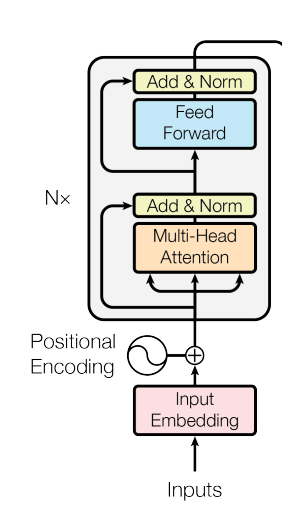

[Antwoord] ...... 


We gaan onze transformer uitbreiden met een positional embedding layer. Deze komt wederom uit de [github van choler](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb) en is gebasseerd op het het paper [attention is al you need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).  


Bestudeer onderstaande code; pas het model aan zodat ipv de reguliere embeddding gebruik wordt gemaakt van onze nieuwe positional embedding en run het opnieuw. 

NB:Voor de vergelijkbaarheid met vorige keer gebruiken we wederom een embedding dimensie (output_dim) van 100

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding( #reguliere embedding
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding( #postitie binnen de embedding
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [ ]:
#geef hier het aangepast model en run het (epochs wederom 5)


In [ ]:
#plot de accuracy, de validated accuracy
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Bekijk het resultaat en probeer te verklaren waarom dit wel of niet werkt

[Antwoord]...

# Sequence 2 sequence
We gaan verder met transformers en deze toepassen in de context waarvoor je ooit zijn bedacht, namelijk vertalen. Groot verschil me de voorgaande situatie is dat we niet alleen een encoder gebruiker maar ook een decoder

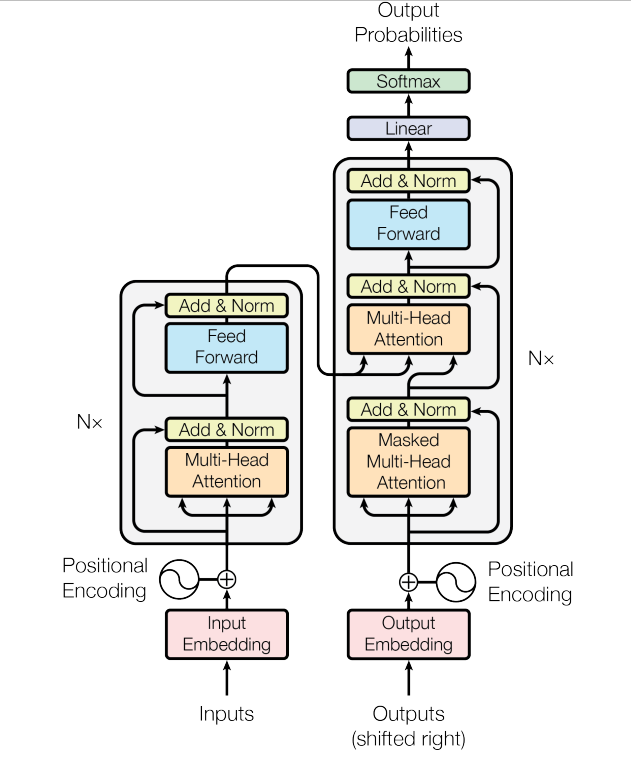

Op de elo vind je een dataset (nedeng.txt) afkomsting van https://tatoeba.org/ waarin met daarin paren van nederlandse en engelse zinnen.

In [ ]:
# open de gegeven dataset nedeng.txt en zorg ervoor dat je een list eng en een list nl aanmaakt
# met de met bij elkaar horende zinnen op dezelfde index
# zet om de nederlandse vertaling steed [start] en [end]
# append beide in de list 'text_pairs'

## Dataprep
De eerste stap die we nu gaan doen is een train_pais en test_pairs list aanmaken 

In [ ]:
from sklearn.model_selection import train_test_split
train_pairs, test_pairs = train_test_split(text_pairs,test_size=0.2,random_state=16, shuffle = True)

test_pairs[0:5] #1e 5 test zinnen tonen

Hieronder volgt een stuk voorbeeldcode (bijna 1-op-1 overgenomen van: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb) 

De onderstaande stappen :
- schonen de train en test datasets op en vectorizen (tokenize en sequence + padding) de zinnen
- converteren de train en test list naar een dataset object met daarin een eng input, een nl input en een target output

Bestudeer onderstaande code (10 min)

In [ ]:
#schoon de zinnen op (lowercase, interpunctie etc.) en vectorize de zinnen [gegeven]

import tensorflow as tf
import string
import re
from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation # vewijder intterpunctie
strip_chars = strip_chars.replace("[", "") #zorgt ervoor dat de [ en ] behouden blijven
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization( #English layer
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

target_vectorization = layers.TextVectorization(#Dutch Layer
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1, standardize=custom_standardization
    # Generate Dutch sentences that have one extra token, since we need to offset
    # the sentence by one step during training
)

train_english_texts = [pair[0] for pair in train_pairs]
train_nl_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_nl_texts)

In [ ]:
# omzetten dataset objecten
batch_size = 64

def format_dataset(eng, nl):
    eng = source_vectorization(eng)
    nl = target_vectorization(nl)
    return ({
        "english": eng,
        "nl": nl[:, :-1], #the input sentence doesn't include the last token, to keep input and target the same length
    }, nl[:, 1:]) #the target sentence is one step ahead. Both are still the samen length (20 words)

def make_dataset(pairs):
    eng_texts, nl_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    nl_texts = list(nl_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, nl_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset #.shuffle(2048).prefetch(16).cache() #in memory caching ivm performance

train_ds = make_dataset(train_pairs)
test_ds = make_dataset(test_pairs)

In [ ]:
#check of alles dezelfde shape heeft
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['nl'].shape: {inputs['nl'].shape}")
    print(f"targets.shape: {targets.shape}")

## De transformer decoder
Nu we de dataprep hebben afgerond kunnen we verder gaan met onze transformerarchitectuur. De encoder en position embbedding hebben we al eerder gedefinieerd dus hoeven we niet opnieuw te doen. Nieuw is de transformer decoder welke we basseren op het attention is all you need paper definieren (zie een stukje hierboven). Bestudeer onderstaande code en vergelijk deze met de afbeelding hierboven. Komt deze overeen? 

In [ ]:
#define de TransformerDecoder
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True #anders geen masking mogelijk

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        #prevents the model from learning to copy the next token from the input to the output by hiden it
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        #Replicate it along the batch axis to get an matrix of shape (batch_size, sequence_length, sequence_length)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        #retrieve the casual mask
        if mask is not None: #prepare the input mask that describes padding locations in the target_sequence
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)#merge both masks
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)# pass the casual mask tot the first attention layer, which performs self attention over the target sequence
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask, #pass the combined mask to the second attention layer, which relates the source sequence to the target sequence
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

Nu we onze decoder ook gedefinieerd hebben, kunnnen we ons model opstellen. We voegen daarom nu ook een decoder blok toe aan ons model, compilen dit, en fitten dit (5 epochs). We stellen de embed_dim en dense-dim 256 en 2048. Het aantal heads houden we op 8.

Tip: check eventueel de cholet voorbeeldcode om te kijken hoe je dit kunt doen https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb

Ca 45 minuten

In [ ]:
#maak een seq2seq model


In [ ]:
#hierna fitten we ons model. Ivm de tijd beperken we ons tot 5 epochs
#Koffie!!

In [ ]:
#testcode
import numpy as np
import random
nl_vocab = target_vectorization.get_vocabulary()
nl_index_lookup = dict(zip(range(len(nl_vocab)), nl_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        #sample next token
        sampled_token = nl_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        #convert the next token to a string and append it to the generated sequence
        if sampled_token == "[end]":
            break #exit condition
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

Wat zien we nu? Hoe goed werkt dit? Hoe zou je de resultaten nog kunnen verbeteren? 

[antwoord] ......